In [1]:
"*ein: http://127.0.0.1:8899/make_figs.ipynb*"
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*<2>"))

SyntaxError: invalid syntax (<ipython-input-1-7bcf22491de6>, line 2)

In [2]:

%pylab inline
import os,sys
import pickle
from importlib import reload
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
import matplotlib as mpl
print(f"Using matplotlib version {mpl.__version__}.")
from matplotlib.gridspec import GridSpec
from scipy.signal import stft
from builtins import sum as bsum

Populating the interactive namespace from numpy and matplotlib
Using matplotlib version 3.6.1.


In [3]:
PLOT = True # Whether to actually make the plots

In [4]:
import boulder;                         reload(boulder)
import crick;                           reload(crick)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
FisherPlumes = fp.FisherPlumes

force_reload = False
if force_reload or ('Fbw' not in locals()):
    pairs_mode = "unsigned"
    Fbw = FisherPlumes("boulder16", freq_max = 20,  which_coords = [(0.45, 0.5)], py_mode = "relative", suffix = 'wideDomain.old',pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
    Fcr = FisherPlumes("n12dishT",  freq_max = 100, which_coords = [(1.0, 0.5)], pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
else:
    Fbw = FisherPlumes(Fbw)
    Fcr = FisherPlumes(Fcr)
    
data = {
    "cr":Fcr,
    "bw":Fbw
}

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


           fisher_plumes 2022/10/26 13:50:55     INFO: ****** LOADING sim_name='boulder16' ******


     fisher_plumes_tools 2022/10/26 13:50:55     INFO: Using relative py coordinates.


     fisher_plumes_tools 2022/10/26 13:50:55     INFO: Loading data from file_name='Re100_0_5mm_50Hz_16source_wideDomain.old.h5'.


INFO:boulder:
Re100_0_5mm_50Hz_16source_wideDomain.old.h5 <BoulderSimulationData>
x_lim: [0.0, 0.5]
y_lim: [-0.21125, 0.21125]
x-y Dimensions: [0.5    0.4225]
x-range: 0.000, 0.001 ... 0.500 (1001 points)
y-range: 0.211, 0.211 ... -0.211 (846 points)
t-range: 0.000, 0.020 ... 60.000 (3001 points)
fs: 50 Hz
Sources:
  0: =    c1a @ (x = +0, y = +0.00375)
  1: =    c1b @ (x = +0, y = -0.00375)
  2: =    c2a @ (x = +0, y = +0.01125)
  3: =    c2b @ (x = +0, y = -0.01125)
  4: =    c3a @ (x = +0, y = +0.01875)
  5: =    c3b @ (x = +0, y = -0.01875)
  6: =    c4a @ (x = +0, y = +0.02625)
  7: =    c4b @ (x = +0, y = -0.02625)
  8: =    c5a @ (x = +0, y = +0.03375)
  9: =    c5b @ (x = +0, y = -0.03375)
 10: =    c6a @ (x = +0, y = +0.04125)
 11: =    c6b @ (x = +0, y = -0.04125)
 12: =    c7a @ (x = +0, y = +0.04875)
 13: =    c7b @ (x = +0, y = -0.04875)
 14: =    c8a @ (x = +0, y = +0.05625)
 15: =    c8b @ (x = +0, y = -0.05625)


     fisher_plumes_tools 2022/10/26 13:50:55  WARNING: Doubling y coordinates because they were wrong in the original data.


INFO:boulder:Mapped coordinate ( 0.450,  0.000) to ( 0.450,  0.000), index (900, 422), name 'x=45 cm'.


INFO:boulder:Field c1a has shape (3001, 1).


INFO:boulder:Field c1b has shape (3001, 1).


INFO:boulder:Field c2a has shape (3001, 1).


INFO:boulder:Field c2b has shape (3001, 1).


INFO:boulder:Field c3a has shape (3001, 1).


INFO:boulder:Field c3b has shape (3001, 1).


INFO:boulder:Field c4a has shape (3001, 1).


INFO:boulder:Field c4b has shape (3001, 1).


INFO:boulder:Field c5a has shape (3001, 1).


INFO:boulder:Field c5b has shape (3001, 1).


INFO:boulder:Field c6a has shape (3001, 1).


INFO:boulder:Field c6b has shape (3001, 1).


INFO:boulder:Field c7a has shape (3001, 1).


INFO:boulder:Field c7b has shape (3001, 1).


INFO:boulder:Field c8a has shape (3001, 1).


INFO:boulder:Field c8b has shape (3001, 1).


     fisher_plumes_tools 2022/10/26 13:51:45     INFO: Computing pairs for len(yvals)=16 from -112500 to 112500 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/26 13:51:45     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2022/10/26 13:51:45     INFO: ****** LOADING sim_name='n12dishT' ******


     fisher_plumes_tools 2022/10/26 13:51:45     INFO: load_sims for sim_name='n12dishT' with which_coords=[(1.0, 0.5)] (py_mode='absolute').


     fisher_plumes_tools 2022/10/26 13:51:45     INFO: Using absolute py coordinates.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.505


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.520


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.510


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-1 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.550


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.500


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.498


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.495


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.490


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=1 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.502


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.480


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.450


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=5 cm.


     fisher_plumes_tools 2022/10/26 13:51:55     INFO: Yvals: [450000, 480000, 490000, 495000, 498000, 500000, 502000, 505000, 510000, 520000, 550000]


     fisher_plumes_tools 2022/10/26 13:51:55     INFO: Computing distance pairings.


     fisher_plumes_tools 2022/10/26 13:51:55     INFO: Computing pairs for len(yvals)=11 from 450000 to 550000 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/26 13:51:55     INFO: Removing duplicates in pairs dictionary.


     fisher_plumes_tools 2022/10/26 13:51:55     INFO: 24 distance pairings found, from 0 to 100000


# Compute all the statistics

In [25]:
wnd_sec = 2.
dmax    = {"bw":np.inf, "cr":np.inf}
wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
[(print(k, end = ""), sys.stdout.flush(), F.compute_all_for_window(wnd = wnd[k],
                                                                   istart = istart[k],
                                                                   window = 'boxcar',
                                                                   tukey_param = 0,
                                                                   dmax = dmax[k],
                                                                   fit_vars = False,                                                                  
)) for k, F in data.items() if k != "acr"];

cr

           fisher_plumes 2022/10/26 14:23:06     INFO: Window set to self.wnd=2000.


           fisher_plumes 2022/10/26 14:23:06     INFO: Computing trig coefficients for n12dishT with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/26 14:23:07     INFO: Computing variances for harmonics.


           fisher_plumes 2022/10/26 14:23:08     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/26 14:23:18     INFO: Computing lambdas.


           fisher_plumes 2022/10/26 14:23:18     INFO: Creating pooling functions.


           fisher_plumes 2022/10/26 14:24:04     INFO: Computing p-values.


           fisher_plumes 2022/10/26 14:24:04     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/26 14:24:21     INFO: Computing R^2-values.


           fisher_plumes 2022/10/26 14:24:21     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2022/10/26 14:24:24     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/26 14:24:24     INFO: Using 24 distances <= inf


           fisher_plumes 2022/10/26 14:24:24     INFO: Computed λ for 1001 frequencies and 24 distances and 51 bootstraps.


           fisher_plumes 2022/10/26 14:24:24     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/26 14:25:27    DEBUG: self.fit_params.shape=(51, 1001, 3).


           fisher_plumes 2022/10/26 14:25:27     INFO: Computing Fisher information (v2).


           fisher_plumes 2022/10/26 14:25:27     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 3000, 4000, 5000, 7000, 8000, 10000, 12000, 15000, 18000, 20000, 22000, 25000, 30000, 40000, 45000, 48000, 50000, 52000, 55000, 60000, 70000, 100000].


           fisher_plumes 2022/10/26 14:25:27     INFO: Done computing all for wnd=2000.


bw

           fisher_plumes 2022/10/26 14:25:27     INFO: Window set to self.wnd=100.


           fisher_plumes 2022/10/26 14:25:27     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/26 14:25:27     INFO: Computing variances for harmonics.


           fisher_plumes 2022/10/26 14:25:27     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/26 14:25:27     INFO: Computing lambdas.


           fisher_plumes 2022/10/26 14:25:27     INFO: Creating pooling functions.


           fisher_plumes 2022/10/26 14:25:29     INFO: Computing p-values.


           fisher_plumes 2022/10/26 14:25:29     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/26 14:25:30     INFO: Computing R^2-values.


           fisher_plumes 2022/10/26 14:25:30     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2022/10/26 14:25:30     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/26 14:25:30     INFO: Using 16 distances <= inf


           fisher_plumes 2022/10/26 14:25:30     INFO: Computed λ for 51 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2022/10/26 14:25:30     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/26 14:25:34    DEBUG: self.fit_params.shape=(51, 51, 3).


           fisher_plumes 2022/10/26 14:25:34     INFO: Computing Fisher information (v2).


           fisher_plumes 2022/10/26 14:25:34     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 15000, 30000, 45000, 60000, 75000, 90000, 105000, 120000, 135000, 150000, 165000, 180000, 195000, 210000, 225000].


           fisher_plumes 2022/10/26 14:25:34     INFO: Done computing all for wnd=100.


In [42]:
fig_dir = f"figs/wnd_{wnd_sec:g}sec"
print(f"Creating {fig_dir=}")
os.mkdir(fig_dir)

Creating fig_dir='figs/wnd_2sec'


# Figure showing an example plume and correlations

In [44]:
DEFAULT = "default"
isdefault = lambda x: x == DEFAULT

INFO:boulder:Loading fld='c1a' at t=40 from full_file='./data/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='./data/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='./data/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='./data/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='./data/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='./data/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='./data/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='./data/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='./data/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='./data/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='./data/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='./data/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='./data/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='./data/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='./data/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='./data/c8b_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y505_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y520_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y510_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y550_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y500_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y498_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y495_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y490_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y502_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y480_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y450_S1_t40.p'.


Wrote figs/wnd_2sec/plumes_demo_bw.pdf.


<ipython-input-44-a64aca252a97>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  isdefault = lambda x: x == DEFAULT


Wrote figs/wnd_2sec/plumes_demo_cr.pdf.


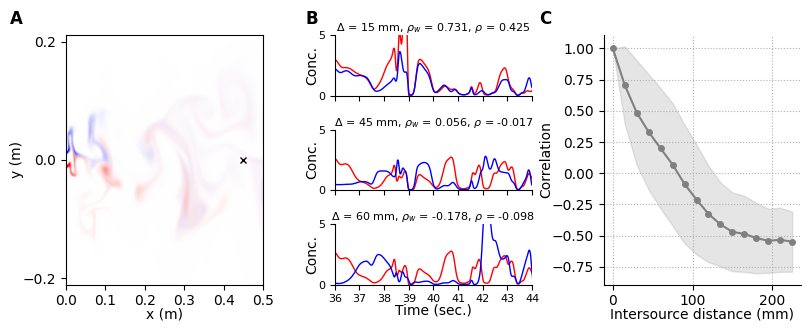

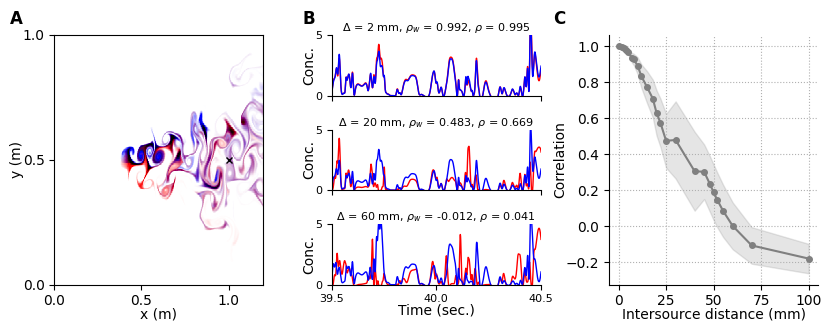

In [59]:
reload(fpf)
reload(fpft)

which_srcs   = {"bw":[-7500, 7500],        "cr":[490000,510000]}
t_wnd        = {"bw":[-4,4],               "cr":[-0.5, 0.5]}
which_idists = {"bw":[0,2,3],              "cr":[0,10,20]}
tticks       = {"bw":DEFAULT,              "cr":[39.5,40,40.5]}
xticks       = {"bw":DEFAULT,              "cr":np.arange(0,1.1,0.5)}
yticks       = {"bw":[-0.2,0,0.2],         "cr":[0,0.5,1]}

for k, F in sorted(data.items()):
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, 40, which_srcs[k], y_lim = (0,5.01), t_wnd = t_wnd[k], dt = 1, which_idists=which_idists[k])
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])

    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir}/plumes_demo_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));    

# Figure showing the distribution of correlations

Wrote figs/wnd_2sec/corr_components_cr.pdf.


Wrote figs/wnd_2sec/corr_components_bw.pdf.


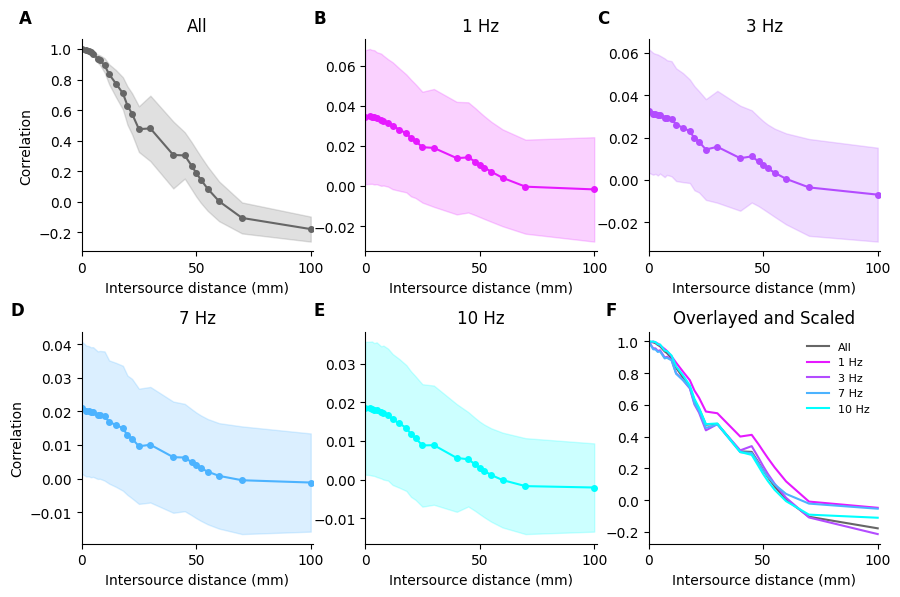

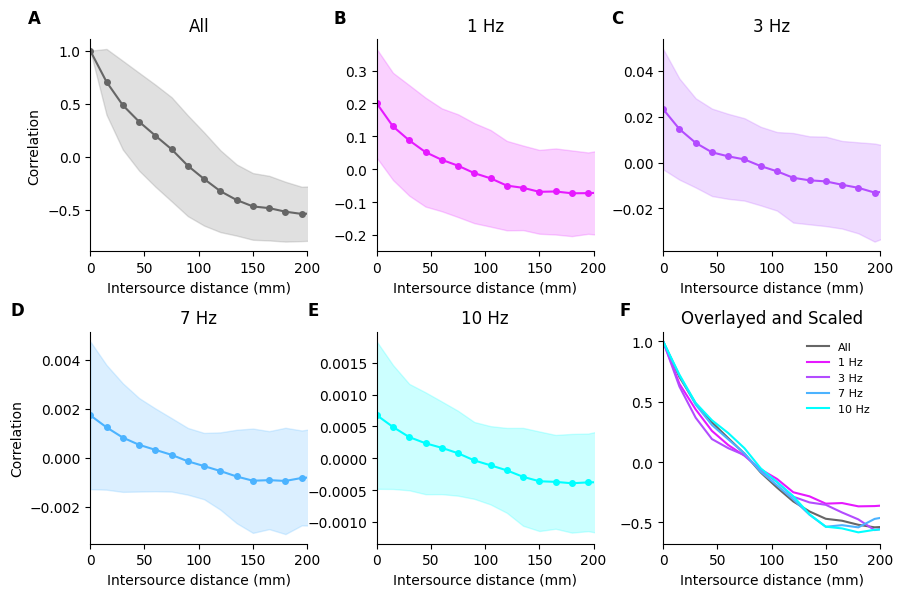

In [65]:
reload(fpf)
which_freqs = [1,3,7,10]
labs = [f"{f} Hz" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f/10) for f in which_freqs])})
xlims_  = {"bw":None, "cr":(0,101)}
xticks_ = {"bw":arange(0,201,50), "cr":arange(0,101,50)}
for k, F in data.items():
    slices = {"All":slice(1,10000)}
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, F.freqs2inds(which_freqs))})
    ax = fpf.plot_correlations(F.rho, xl = (0, 120), slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel("Intersource distance (mm)"),
      (xlims_[k] is not None)  and axi.set_xlim(xlims_[k]),
      (xticks_[k] is not None) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)        
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

Wrote figs/wnd=2sec/coef_vs_coef_bw.pdf.


Wrote figs/wnd=2sec/coef_vs_coef_cr.pdf.


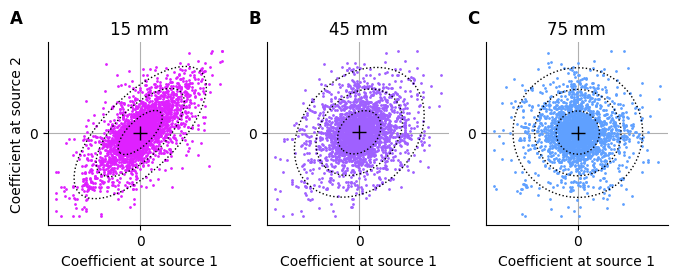

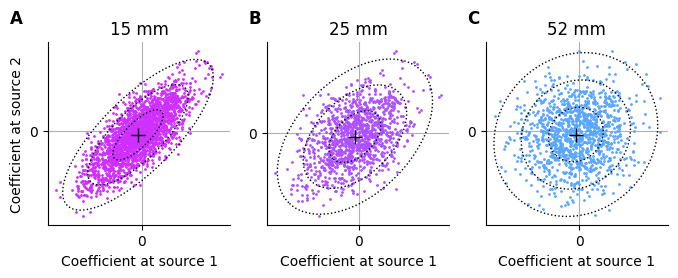

In [37]:
reload(fpf)
which_freqs = {"bw":5,       "cr":10}
which_idists= {"bw":[0,2,4], "cr":[8,12,18]}
dcol_scales = {"bw":120000,  "cr":80000}
for name, F in sorted(data.items()):
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    ax = fpf.plot_coef1_vs_coef2([F.ss, F.cc],
                            ifreq,
                            F.pairs,
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir}/coef_vs_coef_{name}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Supplementary Information

Wrote figs/wnd=2sec/coefs_and_traces_bw_freq1.pdf.


<Figure size 800x300 with 0 Axes>

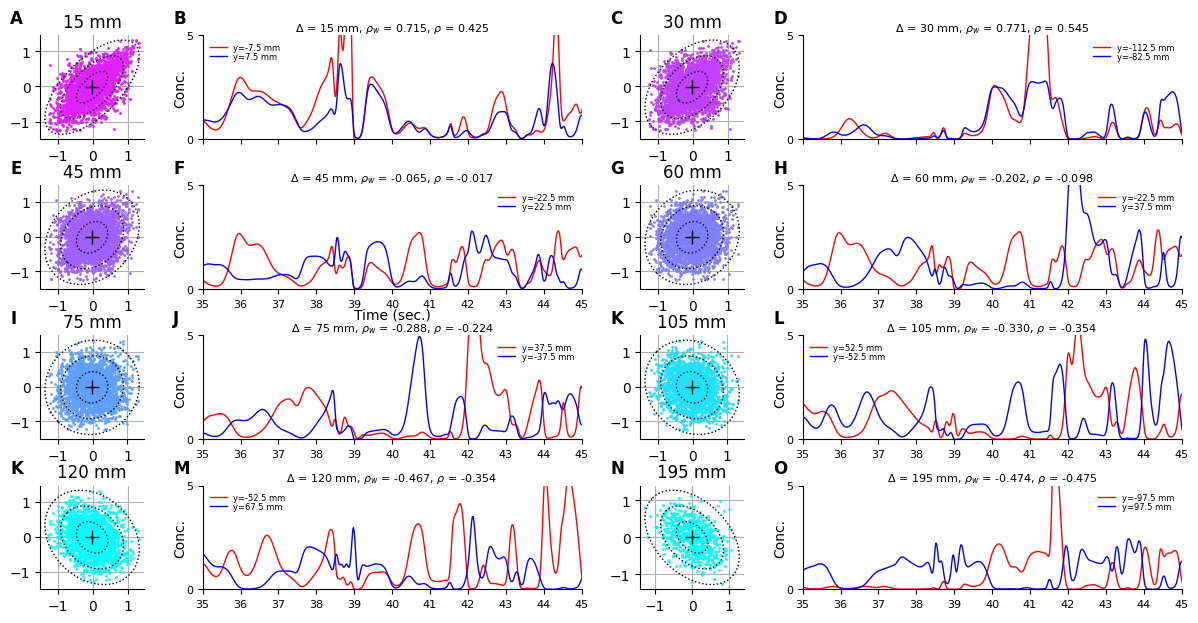

In [38]:
reload(fpft)
freq      = {"bw":1, "cr":5}
idists    = {"bw":[0,1,2,3,4,6,7,12], "cr":[0,4,8,12,16,20,21,22]}
t_lim     = {"bw":[35, 45],       "cr":[39.5,40.5]}
dt        = {"bw":1,              "cr":0.25}
for k, F in sorted(data.items()):
    if k == "cr": continue
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k], n_per_row = 2, y_lim=[0,5], t_lim = t_lim[k], dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    "ABCDEFGHIJKLKMNOPQRSTUVWXYZ",
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir}/coefs_and_traces_{k}_freq{freq[k]}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));    

# Asymmetric Laplacian Fits

d=15000 @ Freq #   2: -np.log10(p) = 7.475
d=30000 @ Freq #   2: -np.log10(p) = 4.270
d=45000 @ Freq #   2: -np.log10(p) = 4.000


Wrote figs/wnd=2sec/alap_fits_bw_ifreq2.pdf.
d=2000 @ Freq #  10: -np.log10(p) = 1.828
d=25000 @ Freq #  10: -np.log10(p) = 0.661
d=52000 @ Freq #  10: -np.log10(p) = 1.984


Wrote figs/wnd=2sec/alap_fits_cr_ifreq10.pdf.


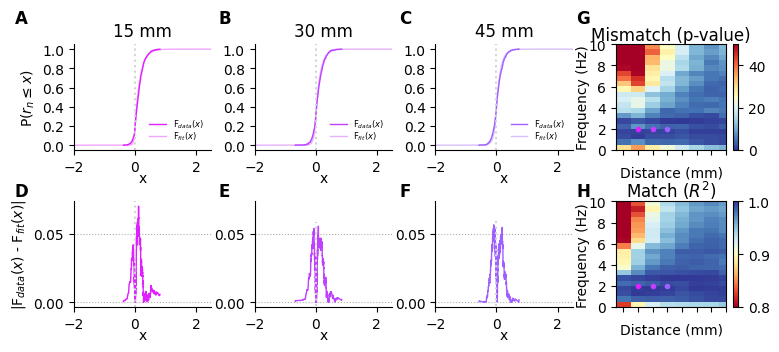

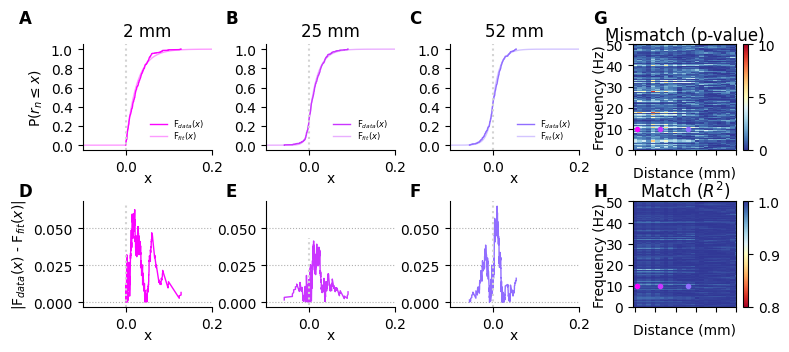

In [40]:
reload(fpf)
#xl        = {"bw":[-0.02,0.025], "cr":[-0.1,0.2]}
xl        = {"bw":[-2,2.5], "cr":[-0.1,0.2]}
idist     = {"bw":[0,1,2],       "cr":[0,12,18]}
ifreq_max = {"bw":21,            "cr":101}
vmin      = {"bw":[0,0.8],        "cr":[0,0.8]}
vmax      = {"bw":[50,1],        "cr":[10,1]}
hxmax     = {"bw":105,          "cr":100}
hmdxt     = {"bw":False,        "cr":True}
which_ifreq = {"bw":2, "cr":10}
for name, F in sorted(data.items()):
    d = np.array(list(F.rho.keys()))
    d = np.sort(d[d>0])
    ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                           ifreq_lim = [1, ifreq_max[name]],
                           xl = xl[name],
                           which_ifreq = which_ifreq[name],
                                                    figsize=(8,3.5),
                                                    vmax=vmax[name],
                                                    vmin=vmin[name],
                           heatmap_xmax = hxmax[name],
                           d_scale = 1000,
                           heatmap_default_xticks = hmdxt[name],
                                                    plot_dvals=True)
    fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                    align_y = [[0,1,2,6],[3,4,5,7]],
                    align_x = [[0,3],[1,4],[2,5]],
                    fontsize=12, fontweight="bold", dy=0)                    
    file_name = f"{fig_dir}/alap_fits_{name}_ifreq{which_ifreq[name]}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

Wrote figs/la_vs_s_fits_bw.pdf.


Wrote figs/la_vs_s_fits_cr.pdf.


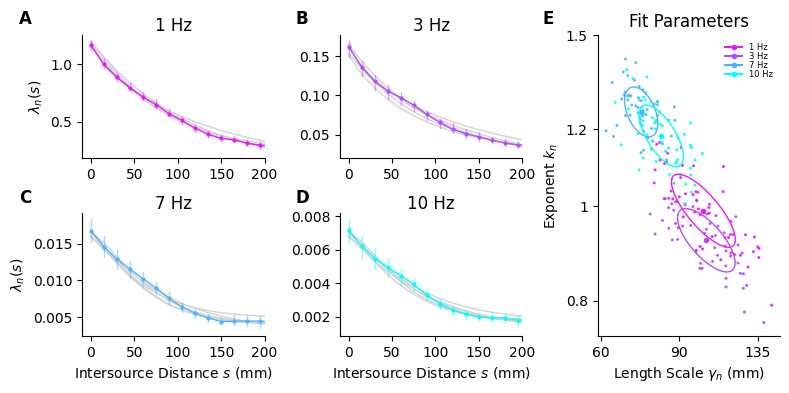

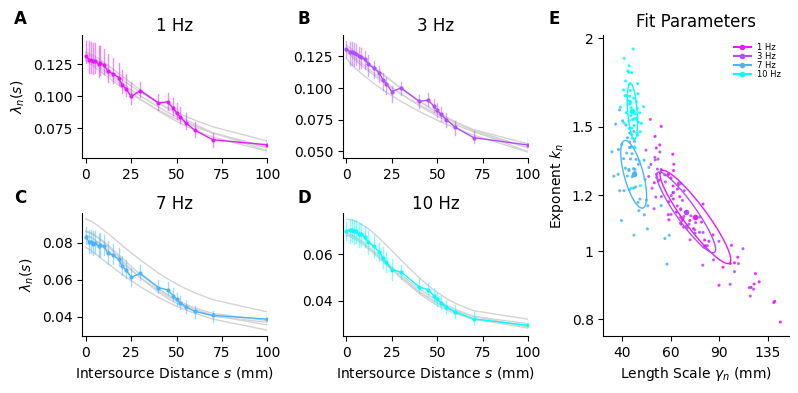

In [12]:
reload(fpft)
reload(fpf)
xl     = {"bw":(-10,200),   "cr": (-2, 50)}
ifreqs = {"bw":[1,3,7,10],  "cr": [1,3,7,10]}
xt     = {"bw":arange(0,201,50), "cr":arange(0,101,25)}
xtp    = {"bw":np.array([60,90,135]), "cr":np.array([40,60, 90, 135])}
ytp    = {"bw":np.array([0.8,1,1.2,1.5]), "cr":np.array([0.8,1,1.2,1.5,2])}
for k, F in sorted(data.items()):
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          xl = xl[k], figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          xt = log10(xtp[k]), yt = log10(ytp[k]),
                                          which_ifreqs = ifreqs[k])
    [(axi.set_xticks(xt[k]), (i>1) and axi.set_xlabel("Intersource Distance $s$ (mm)")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"figs/la_vs_s_fits_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Fisher Information

      fisher_plumes_figs 2022/10/26 13:54:11     INFO: dd[0]=100, dd[-1]=200000


      fisher_plumes_figs 2022/10/26 13:54:11     INFO: Plotting which_ifreqs=[3, 4, 5, 7, 12, 1].


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:505: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fisher.set_xticklabels(ax_fisher.get_xticklabels(), fontsize=8)


      fisher_plumes_figs 2022/10/26 13:54:13     INFO: dd[0]=100, dd[-1]=100000


Wrote figs/fisher_info_bw.pdf.


      fisher_plumes_figs 2022/10/26 13:54:14     INFO: Plotting which_ifreqs=[30, 22, 78, 79, 73, 86, 69, 64, 2].


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:505: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fisher.set_xticklabels(ax_fisher.get_xticklabels(), fontsize=8)


Wrote figs/fisher_info_cr.pdf.


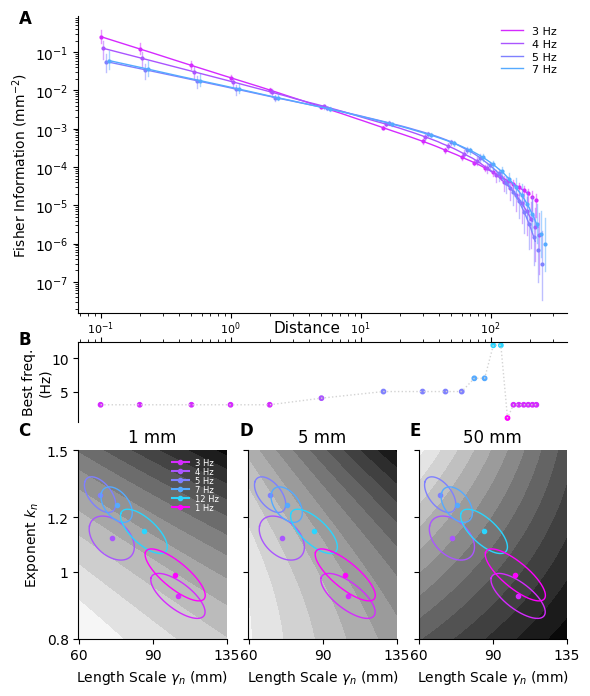

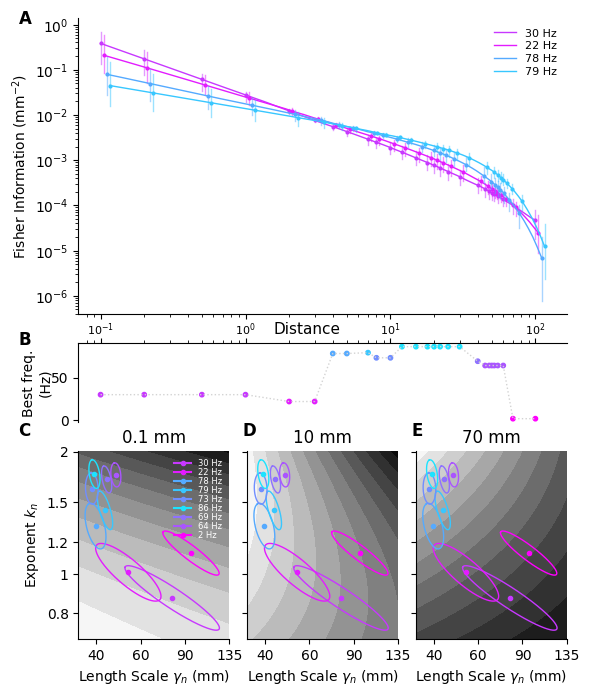

In [13]:
reload(fpf)
#xtp["bw"] = [120, 140]
#xtp["cr"] = [80, 100, 125]
ifreqs["cr"] = [10,20,30,40]
freq_max={"bw":20, "cr":100}
colscale = {"bw":10, "cr":40}
d_vals = {"bw":[1,5,50], "cr":[0.1,10,70]}
d_lim = {"bw":[100, 200000], "cr":[100, 100000]}
bf_ytick = {"bw":arange(0,13,4), "cr":None}
for k, F in sorted(data.items()):
    # if k == "cr": continue
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,                           
                                      d_lim=d_lim[k],
                                      d_range = list(range(100,1000,100)) + list(range(1000,10000,1000))+list(range(10000,60000,10000)),
                                      d_scale = 1000,
                                      d_vals = np.array(d_vals[k])*1000,
                                      d_space_fun = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                      which_ifreqs = ifreqs[k],
                                      x_stagger = lambda x, i: x*(1.05**i),
                                      fi_scale = 1, plot_fun = plt.loglog,
                                      log_scale = True,
                                      freq_max = freq_max[k],
                                      colfun = lambda f: cm.cool_r(f/colscale[k]),
                                      xt = log10(xtp[k]), yt = log10(ytp[k])
    )
    tight_layout(h_pad=0,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    align_y = [[2,3,4]],
                    align_x = [[0,1,2]],
                    fontsize=12, fontweight="bold", dy=-0.01)                            
    file_name = f"figs/fisher_info_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Power in each Signal

Wrote figs/spectra.pdf.


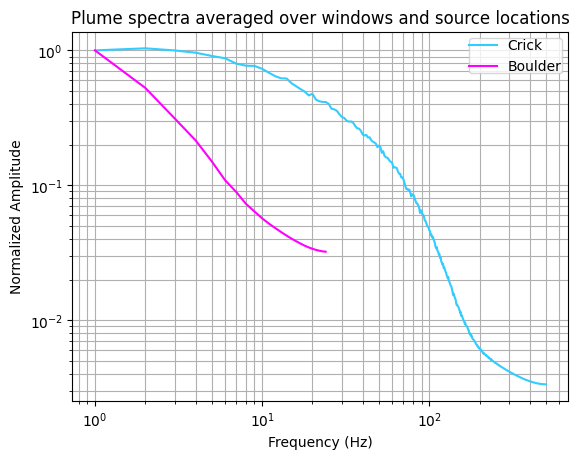

In [14]:
from numpy import fft
from scipy.signal import stft

for k, F in data.items():
    f = []
    for _, s in F.sims.items():
        fr, ti, S = stft(s.data[:,0], fs = F.fs, window='boxcar',
                         nperseg=F.fs, noverlap=F.fs//2, boundary=None, padded=False)
        f.append(np.abs(S))
        
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<F.fs/2][1:],a[fr<F.fs/2][1:]/a[1], label="Crick" if k=="cr" else "Boulder", color={"bw":cm.cool_r(0.0), "cr":cm.cool_r(0.8)}[k])
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized Amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both')
file_name = f"figs/spectra.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));